In [34]:
import pymc as pm
import pandas as pd
from linearmodels.iv import IV2SLS
import arviz as az
from matplotlib import pyplot as plt
import nutpie
import xarray as xr
import numpy as np
import pytensor as pt

In [4]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [5]:
def evaluate_fit(trace):
    display(az.summary(trace, hdi_prob=0.95, round_to=4))
    az.plot_trace(trace)
    plt.tight_layout()

## One-sided non-compliance in experiments - the Bayesian way in PyMC

Sometimes, when running experiments, you can't force everyone in the test group to experience a treatment. While the difference of outcomes in the test vs. control group (average treatment effect, ATE) is still meaningful from the business perspective, sometimes you want to capture the effect of the treatment on those who actually experienced it (average treatment effect on the treated, ATT). There are a couple of ways to do it, with one of them being an instrumental variable approach. 

The same instrumental variable approach can also be used to analyze encouragement designs - situations where both test & control groups have access to the treatment, but the test group is nudged to actually use it. The randomization of treatment makes it a perfect instrument and we can estimate ATT using the IV approach. For more background, see Spotify's [blog post](https://engineering.atspotify.com/2023/08/encouragement-designs-and-instrumental-variables-for-a-b-testing/) on the topic.

A while ago, I came across a [Stan case study](https://mc-stan.org/learn-stan/case-studies.html#volume-10-2023) on replicating the IV approach on one-sided non-compliance situations in experiments with a bayesian model, including a version that relaxes the exclusion restriction assumption. In this post, I will replicate the case study in PyMC, show how we can get tighter estimates with better priors and make the model faster with sufficient statistics.

## Stan case study

The case study analyses a one-sided non-compliance in an [experiment](https://pubmed.ncbi.nlm.nih.gov/2006355/) where villagers in Indonesia where randomly assigned to receive vitamin A, with the outcome of interest being infant mortality. The experiment had nearly 24k participants, split at 50/50 ratio, but only 80% of the participants in the test group actually took the medication.

I'll use the same notation as in the case study, where $Z$ is the randomization assignment, $W$ is the treatment compliance, and $Y$ is the outcome.

In [6]:
df = pd.read_csv("inputs.csv")
df.rename(
    columns={"Y": "survived (Y)", "Z": "in_test_group (Z)", "W": "took_vitamins (W)"}
).groupby(["in_test_group (Z)", "took_vitamins (W)"]).aggregate(
    {"survived (Y)": ["mean", "size"]}
)

survived (Y)       
                                            mean   size
in_test_group (Z) took_vitamins (W)                    
0                 0                     0.993614  11588
1                 0                     0.985945   2419
                  1                     0.998760   9675

### Instrumental variable approach

One approach to estimating ATT in this scenario is by using $Z$, the randomized treatment assignment, as the instrument for the actual treatment $W$. We obtain an estimate of ATT of $0.0032$, with 95% CI of $[0.0010; 0.0055]$  

In [7]:
print(IV2SLS.from_formula(formula="Y ~ 1 + [W ~ Z]", data=df).fit().summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.9936     0.0007     1342.8     0.0000      0.9922      0.9951
W              0.0032     0.0012     2.7848     0.0054      0.0010      0.0055


Because this is a situation of a one-sided non compliance (vs. an encouragement design where treatment is available to both test and control groups), an IV model is actually not needed. We can get the same results by simply comparing the outcomes of the treated and untreated in the test group via a t-test or an an equivalent linear regression, and adjusting for compliance rate in the test group.

In [8]:
compliance_rate = df[df["Z"] == 1]["W"].mean()
fit = IV2SLS.from_formula(formula="Y ~ 1 + Z", data=df).fit()
print(fit.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.9936     0.0007     1342.8     0.0000      0.9922      0.9951
Z              0.0026     0.0009     2.7833     0.0054      0.0008      0.0044


In [9]:
print(
    "ATT: {Z:.4f} | 95CI: [{lower:.4f}; {upper:.4f}]".format(
        Z=fit.params["Z"] / compliance_rate,
        **(fit.conf_int().iloc[1] / compliance_rate).to_dict(),
    )
)

ATT: 0.0032 | 95CI: [0.0010; 0.0055]


### The bayesian version

The approach outlined in the Stan case study is based on a [1997 paper from Guido and Imbens](https://projecteuclid.org/journals/annals-of-statistics/volume-25/issue-1/Bayesian-inference-for-causal-effects-in-randomized-experiments-with-noncompliance/10.1214/aos/1034276631.full), and, at least in my eyes, is a very elegant representation of the potential outcomes framework. The original case study does a [great job of outlining the maths](https://mc-stan.org/learn-stan/case-studies/cace_one-sided.html#causal-estimands) behind the causal estimands, so I'll just present a quick summary. The idea is as follows:
 * We model probability of survival among compliers in the test group ($Y=1|Z=1, W=1$) with $\eta_{c1}$
 * We model probability of survival among never takes in the test group ($Y=1|Z=1, W=1$) with $\eta_{n}$
 * We model the compliance rate itself in the test group ($W1|Z=1$) with $\pi_{c}$
 * We don't know who is a complier vs. never-taker in the control group, so for each individual outcome in the control group, we assign a mixture probability of being a complier or never-taker, with the mixture probability being the compliance rate in the test group ($\pi_{c}$). The probability of survival among compliers in the control group is modelled as $\eta_{c0}$. 
 * In the first instance, we assume the _exclusion restriction_, i.e. that the randomization itself has no effect on the outcome; as a result we can assume that never-takers in the control group would have the same survival probability as the never-takers in the test group, $\eta_{n}$.
 * Finally, the parameter of interest, the ATT (referred to as CACE in the original case study), is $$ATT = \eta_{c1} - \eta_{c0}$$.

The original case study uses uninformative priors, leading to the following model structure:

$$
\pi_c \sim \text{Beta}(2, 2) \\
\eta_{c1} \sim \text{Beta}(2, 2) \\
\eta_{c0} \sim \text{Beta}(2, 2) \\
\eta_{n} \sim \text{Beta}(2, 2) \\
Y_i|Z=1,W=1 \sim \text{Bernoulli}(\eta_{c1}) \\
Y_i|Z=1,W=0 \sim \text{Bernoulli}(\eta_{n}) \\
Y_i|Z=0 \sim \pi_c* \text{Bernoulli}(\eta_{c0}) + (1 - \pi_c)\text{Bernoulli}(\eta_{c0}) \\
W_i|Z=1 \sim \text{Bernoulli}(\pi_c) \\

$$

Below I refit the original Stan model.

In [10]:
stan_code = """
data {
  int<lower=1> N;                    // Sample size N 
  array[N] int<lower=0, upper=1> Z;  // Treatment assigned Z
  array[N] int<lower=0, upper=1> W;  // Treatment received W
  array[N] int<lower=0, upper=1> Y;  // Outcome Y
}

parameters {
  // Population probability of being a complier
  real<lower=0, upper=1> pi_c;
  
  // Probabilities for the binomial outcome distributions
  real<lower=0, upper=1> eta_c0;
  real<lower=0, upper=1> eta_c1;
  real<lower=0, upper=1> eta_n;
}  

model {
  // Define local variables for efficiency
  real log_pi_c = log(pi_c);
  real log1m_pi_c = log1m(pi_c);
  
  // Prior for Complier probability
  // implicit prior: pi_c ~ Unif(0, 1)
  
  // Priors for outcome model parameters
  pi_c ~ beta(2, 2);
  eta_c0 ~ beta(2, 2);  
  eta_c1 ~ beta(2, 2);  
  eta_n ~ beta(2, 2); 

  // Likelihood
  for(n in 1:N){
    
    // Complier (assigned to treatment)
    if (Z[n] == 1 && W[n] == 1){
      target += log_pi_c + bernoulli_lpmf(Y[n] | eta_c1) ;
    }
    
    // Never-taker (assigned to treatment)
    else if (Z[n] == 1 && W[n] == 0){
      target +=  log1m_pi_c + bernoulli_lpmf(Y[n] | eta_n);
    }
    
    // Complier or Never-taker (assigned to control)
    else if (Z[n] == 0 && W[n] == 0){
      target += log_mix(
        pi_c,                           // Complier probability
        bernoulli_lpmf(Y[n] | eta_c0),  // Complier
        bernoulli_lpmf(Y[n] | eta_n)    // Never-taker
      );  
    }
  }
}

generated quantities {
  // Superpopulation complier average causal effect (ATT)
  real ATT = (eta_c1 - eta_c0);  
  real never_taker_effect = (eta_n - eta_c0);  
}
"""

In [11]:
stan_data = {
    "N": df.shape[0],
    "Y": df["Y"].to_numpy(),
    "Z": df["Z"].to_numpy(),
    "W": df["W"].to_numpy(),
}

In [12]:
def reshape_trace(trace, group="posterior"):
    """
    Reshape the trace to a more convenient format for plotting.
    """
    tr = trace.copy()
    tr[group]["survival_rate"] = xr.concat(
        [
            tr[group]["eta_c0"],
            tr[group]["eta_c1"],
            tr[group]["eta_n"],
        ],
        dim="segment",
    ).assign_coords(segment=["control_group", "compliers", "never-takers"])

    tr[group] = (
        tr[group]
        .rename_vars({"pi_c": "probability_to_comply"})
        .drop_vars(["eta_c1", "eta_n", "eta_c0"])
    )
    return tr


In [13]:
nutpie_compiled_stan_model_original = nutpie.compile_stan_model(
    code=stan_code
).with_data(**stan_data)

stan_trace_raw = nutpie.sample(
    nutpie_compiled_stan_model_original,
    chains=4,
    tune=1000,
    draws=2000,
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,3000,0,0.95,3
,3000,0,0.91,7
,3000,0,0.87,3
,3000,0,0.93,3


In [14]:
trace_stan_nutpie_original = reshape_trace(stan_trace_raw)

Just like the original case study, we get the pretty much the same results as the IV approach. I've also included the "never taker effect" as one of the outcomes that we get when we approach this problem from the potential outcomes perspective. The never-taker effect is the difference in outcomes between the never-takers (in either of the groups - we're have the exclusion restriction assumption) and control group (that would comply if they were in the test group). This is not an estimate we get using the IV approach - and while it's not of primary interest, it can be useful to have it. In this case, we see that the never-taker effect is negative, suggesting that this population, overall, has worse survival rates that the complying population.

In [15]:
az.summary(
    trace_stan_nutpie_original,
    hdi_prob=0.95,
    round_to=4,
    var_names=["survival_rate", "probability_to_comply", "ATT", "never_taker_effect"],
)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
survival_rate[control_group],0.9953,0.0011,0.9932,0.9975,0.0,0.0,4954.0665,4119.1229,1.0001
survival_rate[compliers],0.9986,0.0004,0.9978,0.9993,0.0,0.0,9705.6213,5693.6899,0.9999
survival_rate[never-takers],0.9855,0.0024,0.9809,0.9902,0.0,0.0,5198.6363,5471.9421,1.0000
probability_to_comply,0.8000,0.0037,0.7928,0.8070,0.0,0.0,10420.9282,6015.9690,1.0011
ATT,0.0032,0.0012,0.0008,0.0054,0.0,0.0,5180.4140,4168.8825,1.0001
never_taker_effect,-0.0099,0.0031,-0.0159,-0.0038,0.0,0.0,4546.4518,4725.7932,1.0001


## PyMC implementation

Now, let's replicate the same model in PyMC. To start with, I'll replicate the original Stan model 1:1, leaving optimizations for later.

The full generative model is below. 

In [94]:
with pm.Model(
    # we're using mutable coordinates to be able to use pm.observe() later
    coords_mutable={
        "compliers_i": [0],
        "never_takers_i": [0],
        "control_group_i": [0],
        "test_group_i": [0],
    }
) as uninformative_prior_model:

    # probability to comply
    pi_c = pm.Beta("pi_c", alpha=2, beta=2)  
    # survival probability for compliers in control group
    eta_c0 = pm.Beta("eta_c0", alpha=2, beta=2)  
    # survival probability for compliers in treatment group
    eta_c1 = pm.Beta("eta_c1", alpha=2, beta=2)
    # survivival probability for never takers
    eta_n = pm.Beta("eta_n", alpha=2, beta=2)

    # compliers
    pm.Bernoulli("compliers", p=eta_c1, dims=["compliers_i"])

    # never takers
    pm.Bernoulli("never_takers", p=eta_n, dims=["never_takers_i"])    

    # control group
    pm.Mixture(
        "control_group",
        w=pm.math.stack([pi_c, 1 - pi_c]),
        comp_dists=pm.Bernoulli.dist(p=pm.math.stack([eta_c0, eta_n])),
        dims=["control_group_i"],
    )

    # add probability to comply
    pm.Bernoulli("test_group", p=pi_c, dims=["test_group_i"])

    pm.Deterministic(
        "ATT", (eta_c1 - eta_c0)
    )  # average treatment effect among compliers

    pm.Deterministic(
        "never_taker_effect", (eta_n - eta_c0)
    )  # difference between never takers and compliers in control group

Now let's assign observed data to the model using `pymc.observe()`. We could have done it in the previous step, but having a model without the data will speed up prior predictive sampling that we'll need later. Unfortunately, it's a bit tedious to do it, as we need to both assign the data and update corresponding dimension attributes for everything to work.

In [137]:
def assign_data(model, data):
    """
    Assigns data to the model's observed variables.
    """
    
    # create a model with observed data
    model_with_data = pm.observe(
        model,
        {
            model.compliers: data[data["W"] == 1]["Y"].to_numpy(),
            model.never_takers: data[(data["Z"] == 1) & (data["W"] == 0)]["Y"].to_numpy(),
            model.test_group: data[data["Z"] == 1]["W"].to_numpy(),
            model.control_group: data[data["Z"] == 0]["Y"].to_numpy(),
        },
    )

    #update the dimensions of the model to match the data
    model_with_data.set_dim(
        "compliers_i",
        len(data[data["W"] == 1]["Y"]),
        coord_values=np.arange(len(data[data["W"] == 1]["Y"])),
    )
    model_with_data.set_dim(
        "never_takers_i",
        len(data[(data["Z"] == 1) & (data["W"] == 0)]["Y"]),
        coord_values=np.arange(len(data[(data["Z"] == 1) & (data["W"] == 0)]["Y"])),
    )
    model_with_data.set_dim(
        "control_group_i",
        len(data[data["Z"] == 0]["Y"]),
        coord_values=np.arange(len(data[data["Z"] == 0]["Y"])),
    )
    model_with_data.set_dim(
        "test_group_i",
        len(data[data["Z"] == 1]["W"]),
        coord_values=np.arange(len(data[data["Z"] == 1]["W"])),
    )

    return model_with_data

uninformative_prior_model_with_data = assign_data(
    uninformative_prior_model, df
)

Now we can sample from the model:

In [97]:
with uninformative_prior_model_with_data:
    pymc_uninformative_trace_raw = pm.sample(
        draws=2000, tune=1000, chains=4, nuts_sampler="nutpie"
    )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,3000,0,0.90,3
,3000,0,0.94,3
,3000,0,0.94,3
,3000,0,0.89,7


In [98]:
pymc_uninformative_trace = reshape_trace(pymc_uninformative_trace_raw)

Here we have the same results again. So far so good.

In [99]:
az.summary(
    pymc_uninformative_trace,
    hdi_prob=0.95,
    round_to=4,
    var_names=["survival_rate", "probability_to_comply", "ATT", "never_taker_effect"],
)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
survival_rate[control_group],0.9954,0.0011,0.9930,0.9974,0.0,0.0,5185.6939,3958.5810,1.0000
survival_rate[compliers],0.9985,0.0004,0.9978,0.9993,0.0,0.0,11053.5184,5959.6158,1.0010
survival_rate[never-takers],0.9855,0.0024,0.9809,0.9902,0.0,0.0,5407.7548,5786.3456,1.0002
probability_to_comply,0.7999,0.0036,0.7928,0.8070,0.0,0.0,10155.5546,6583.5398,1.0002
ATT,0.0032,0.0012,0.0009,0.0055,0.0,0.0,5499.5752,4447.9309,1.0004
never_taker_effect,-0.0099,0.0031,-0.0160,-0.0038,0.0,0.0,4708.9164,4901.7181,1.0002


## Improving the model

I'd argue that there are a few improvements we could make to the priors in the original model, though. It's easiest to illustrate them by looking at the prior distributions and trying to understand what they actually imply.

In [100]:
with uninformative_prior_model:
    pymc_uninformative_trace_raw.extend(pm.sample_prior_predictive(draws=5000))

Sampling: [compliers, control_group, eta_c0, eta_c1, eta_n, never_takers, pi_c, test_group]


There are two things that stand out looking at the below charts:
 * A flat prior ($\text{Beta}(2, 2)$) for the infant survival probabilities may not be the best choice - as it suggests survival rates anywhere between 10% and 90%. Surely, we have some prior knowledge that we could leverage here. In the observed data, the survival rates are close to 99%! In real world, we shouldn't be "double-dipping", but a prior that places most of density above 80% survival rate or so seems appropriate.
  
 * The priors for $\eta_{c0}$, $\eta_{c1}$ and $\eta_{n}$ are independent, which leads to a very flat prior to the implied prior on the $ATT$. In the original model, the prior on the $ATT$ has most of its density between -60% and +60% change in the survival rate! The same applies the for "never-taker" effect. This is clearly not realistic - we wouldn't expect taking vitamins to change the odds of survival that much! Instead of modelling each of the $\eta$ independently, we should directly model the $ATT$ itself and apply it on the baseline survival rate to get appropriate prior for the survival rate among compliers (and similarly - never takers). 

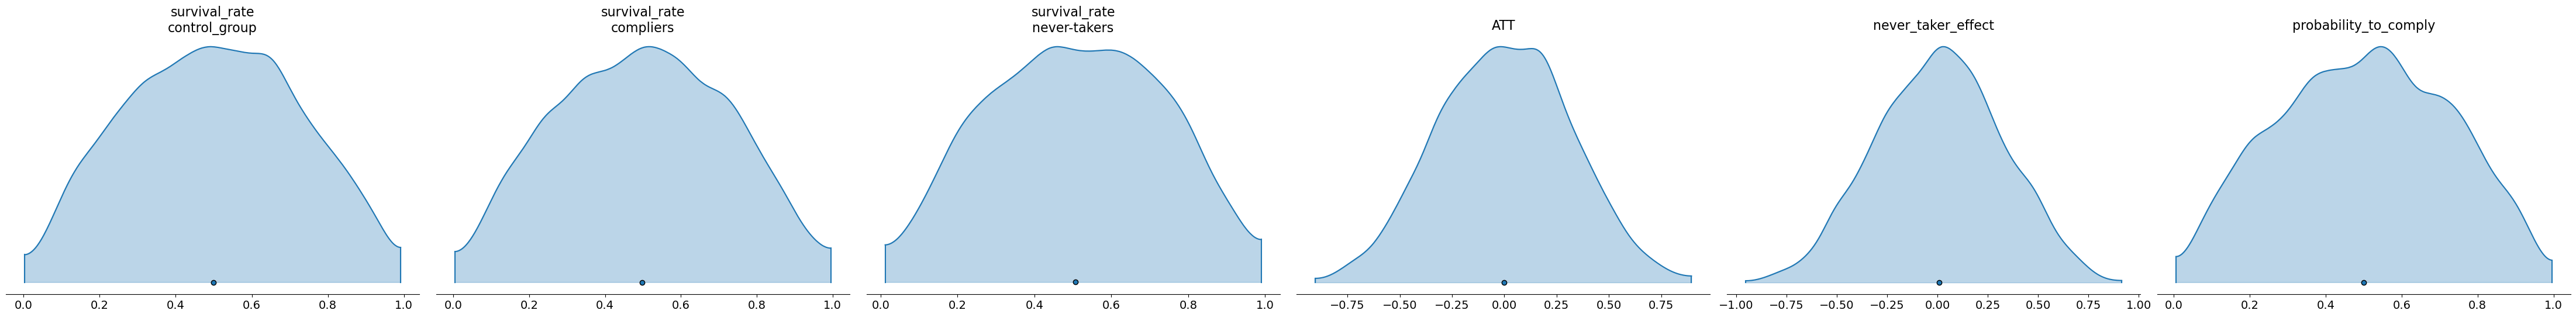

In [101]:
az.plot_density(
    reshape_trace(pymc_uninformative_trace_raw, group="prior"),
    group="prior",
    var_names=["survival_rate", "ATT", "never_taker_effect", "probability_to_comply"],
    hdi_prob=1,
    shade=0.3,
    grid=(1, 6),
)

plt.tight_layout()

To achieve the above changes, I'll reparameterize the model to work in the log-odds space (easier to avoid boundary issues), and replace the priors with more appropriate ones.

The updated model then looks like this:

$$
\gamma \sim \text{Normal}(0, 1) \\
\alpha \sim \text{Normal}(1.5, 0.5) \\ 
\beta_{c} \sim \text{Normal}(0, 0.2) \\ 
\beta_{nt} \sim \text{Normal}(0, 0.2) \\ 
$$

$$
\pi_{c} = \text{inv\_logit}(\gamma) \\
\eta_{c0} = \text{inv\_logit}(\alpha) \\
\eta_{c1} = \text{inv\_logit}(\alpha + \beta{c}) \\
\eta_{n} = \text{inv\_logit}(\alpha + \beta{nt}) \\
$$

$$
Y_i|Z=1,W=1 \sim \text{Bernoulli}(\eta_{c1}) \\
Y_i|Z=1,W=0 \sim \text{Bernoulli}(\eta_{n}) \\
Y_i|Z=0 \sim \pi_c* \text{Bernoulli}(\eta_{c0}) + (1 - \pi_c)\text{Bernoulli}(\eta_{c0}) \\
W_i|Z=1 \sim \text{Bernoulli}(\pi_c) \\
$$


And here's the pyMC specification (wrapped in a function so we can reuse it later):

In [134]:
def bayes_model(priors={
        "γ": dict(mu=0, sigma=1.1),
        "α": dict(mu=1.5, sigma=0.5),
        "β": dict(mu=[0, 0], sigma=[0.2, 0.2]),
    },):

    with pm.Model(
        coords={"segment": ["control_group", "compliers", "never-takers"]},
        coords_mutable={
            "compliers_i": [0],
            "never_takers_i": [0],
            "control_group_i": [0],
            "test_group_i": [0],
        }
    ) as m:
        γ = pm.Normal("γ", **priors["γ"])
        α = pm.Normal("α", **priors["α"])

        # the "treatment" effect is fixed to 0 for control group
        β = pm.Deterministic(
            "β",
            pm.math.concatenate(
                [pt.tensor.zeros(1), pm.Normal("β_", **priors["β"])]
            ),
            dims="segment",
        )

        # compliers
        pm.Bernoulli("compliers", logit_p=α + β[1], dims="compliers_i")

        # never takers
        pm.Bernoulli("never_takers", logit_p=α + β[2], dims="never_takers_i")

        # add probability to comply
        pm.Bernoulli("test_group", logit_p=γ, dims="test_group_i")

        # deterministics
        η = pm.Deterministic("survival_rate", pm.invlogit(α + β), dims="segment")
        pm.Deterministic("ATT", (η[1] - η[0]))
        pm.Deterministic("never_taker_effect", (η[2] - η[0]))
        π = pm.Deterministic("probability_to_comply", pm.invlogit(γ))

        # control group
        pm.Mixture(
            "control_group",
            w=pm.math.stack([π, 1 - π]),
            comp_dists=pm.Bernoulli.dist(logit_p=pm.math.stack([α, α + β[2]])),
            dims="control_group_i",
        )
    return m

In [124]:
informative_prior_model = bayes_model()

Let's sample from the priors again and make sure these priors make sense / are actually different from the original ones.

In [125]:
with informative_prior_model:
    pymc_informative_trace = pm.sample_prior_predictive(draws=5000)

Sampling: [compliers, control_group, never_takers, test_group, α, β_, γ]


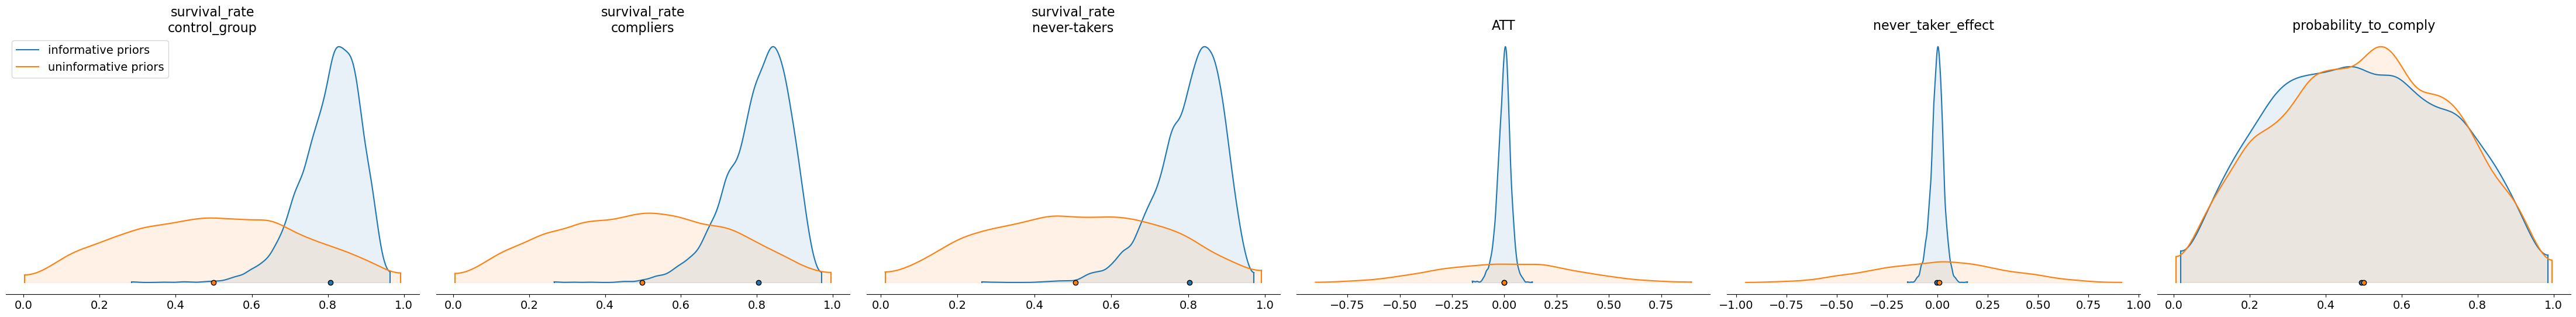

In [126]:
az.plot_density(
    [
        pymc_informative_trace,
        reshape_trace(pymc_uninformative_trace_raw, group="prior"),
    ],
    group="prior",
    data_labels=["informative priors", "uninformative priors"],
    var_names=["survival_rate", "ATT", "never_taker_effect", "probability_to_comply"],
    hdi_prob=1,    
    shade=0.1,
    grid=(1, 6),    
)

plt.tight_layout()

This looks much better! Let's go ahead and fit the model.

In [127]:
informative_prior_model_with_data = assign_data(
    informative_prior_model, df
)

with informative_prior_model_with_data:
    pymc_informative_trace.extend(
        pm.sample(
            draws=2000,
            tune=1000,
            chains=4,
            nuts_sampler="nutpie",  # progressbar=False
        )
    )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,3000,0,0.98,3
,3000,0,0.93,7
,3000,0,0.89,3
,3000,0,0.95,3


And, voila - we get more tighter estimates! The standard error for ATT is down to $0.007$, which is nearly a 2x reduction, with the point estimate remaining the same.

In [128]:
az.summary(
    pymc_informative_trace,
    hdi_prob=0.95,
    round_to=4,
    var_names=["survival_rate", "probability_to_comply", "ATT", "never_taker_effect"],
)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
survival_rate[control_group],0.9936,0.0007,0.9922,0.9949,0.0,0.0,5015.9404,5690.6455,1.0001
survival_rate[compliers],0.9969,0.0005,0.9960,0.9978,0.0,0.0,12907.5119,6692.0401,1.0004
survival_rate[never-takers],0.9906,0.0013,0.9880,0.9930,0.0,0.0,11978.8078,7031.9391,0.9998
probability_to_comply,0.7999,0.0036,0.7929,0.8073,0.0,0.0,9506.5329,6095.5919,1.0011
ATT,0.0033,0.0007,0.0020,0.0046,0.0,0.0,5057.5980,5875.4412,1.0004
never_taker_effect,-0.0029,0.0013,-0.0057,-0.0004,0.0,0.0,6804.7193,6770.0664,0.9999


Here are all the models we fit so far. Notice that while ATT point estimates are largely the same across all models, the never-taker effect is smaller in the informed prior model. 

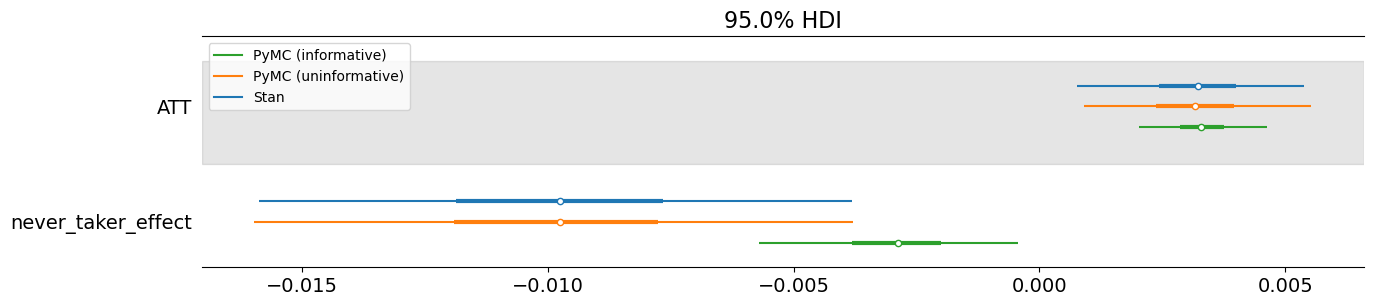

In [129]:
az.plot_forest(
    [
        trace_stan_nutpie_original,
        pymc_uninformative_trace,
        pymc_informative_trace,        
    ],
    var_names=["ATT", "never_taker_effect"],
    hdi_prob=0.95,
    combined=True,
    model_names=[
        "Stan",
        "PyMC (uninformative)",
        "PyMC (informative)",        
    ],
    figsize=(15, 3),
)
plt.show()

This is due to the prior we imposed that limits the probable range of the never-taker effect. We're effectively shrinking all the estimates towards the prior mean - as it can be even more clearly seen if we plot the posterior distributions for the survival rates themselves. This also illustrates the danger of using priors that are "too informed" - we can end up shrinking the estimates too much.

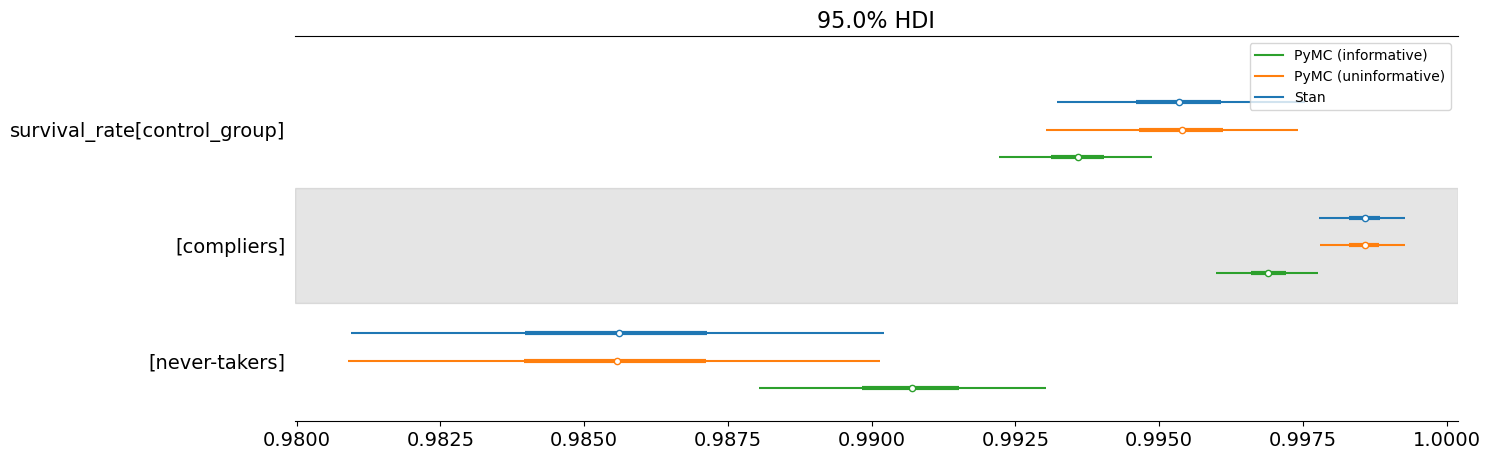

In [130]:
az.plot_forest(
    [
        trace_stan_nutpie_original,
        pymc_uninformative_trace,
        pymc_informative_trace,        
    ],
    var_names=["survival_rate"],
    hdi_prob=0.95,
    combined=True,
    model_names=[
        "Stan",
        "PyMC (uninformative)",
        "PyMC (informative)",        
    ],
    figsize=(15, 5),
)
plt.show()

## How dangerous are "too informed" priors?

To better understand what happens when we use flat vs. weak vs. strong priors, let's simulate some data where we know what the ground truth is. Suppose that:

* We have 5000 individuals in the test group, and 5000 in the control group
* We'll assume 30% compliance rate
* We'll also assume that the indviduals who comply have by far better baseline outcome rates (35% vs. 25%); i.e. never-taker effect is -10%.
* We'll assume that the treatment effect is negative, and it reduces the outcome by 5%.



In [131]:
real_compliance_rate = 0.3
outcome_rates = np.array([0.25, 0.35])
treatment_effect = np.array([0, -0.05])
n_per_group = 5_000


def simulate_data(compliance_rate, baselines, att, n, random_seed=123456):
    rng = np.random.default_rng(random_seed)

    # draw compliance status for each individual
    individuals = pm.draw(
        pm.Bernoulli.dist(p=compliance_rate, shape=2), draws=n, random_seed=rng
    )

    # apply baseline outcome rate based on whether complier or never-taker
    baseline_probability = baselines[individuals]

    # apply treatment effect based on whether in the treatment group and whether a complier
    treated_probability = baseline_probability + (
        att[individuals] * np.array([0, 1]).reshape(1, -1)
    )

    # draw outcome based on the probabilities
    outcomes = pm.draw(
        pm.Bernoulli.dist(p=treated_probability), draws=1, random_seed=rng
    )

    return pd.DataFrame(
        {
            "Z": [0, 1] * n,
            "true_complier": individuals.ravel(),
            "W": (individuals * np.array([0, 1])).ravel(),
            "baseline_prob": baseline_probability.ravel(),
            "treated_prob": treated_probability.ravel(),
            "Y": outcomes.ravel(),
        }
    )

In [132]:
simulated_df = simulate_data(
    compliance_rate=real_compliance_rate,
    baselines=outcome_rates,
    att=treatment_effect,
    n=n_per_group,
)

In [165]:
simulated_df.groupby(["Z", "true_complier"]).aggregate(
    {"Y": ["mean", "size", "sum"]}
).reset_index()

Z true_complier         Y           
                        mean  size  sum
0  0             0  0.255041  3521  898
1  0             1  0.345504  1479  511
2  1             0  0.251574  3494  879
3  1             1  0.292165  1506  440

In [114]:
estimators = []


def oracle_model(sim_df):
    fit = IV2SLS.from_formula(
        formula="Y ~ 1 + true_complier + true_complier:Z", data=sim_df
    ).fit()
    return dict(
        zip(
            ["name", "mean", "st_error", "t_stat", "p_value", "lower_ci", "upper_ci"],
            fit.summary.tables[1][3].data,
        )
    )


def iv_estimator(sim_df):
    fit = IV2SLS.from_formula(formula="Y ~ 1 + [W ~ Z]", data=sim_df).fit()
    return dict(
        zip(
            ["name", "mean", "st_error", "t_stat", "p_value", "lower_ci", "upper_ci"],
            fit.summary.tables[1][2].data,
        )
    )

Now, let's define a few models with different prior assumptions:
 * Model 1: flat priors for everything, similar to the ones in the original case study ("classical" model)
 * Model 2: weak priors. We make good guesses on feature usage rate itself $\gamma$ as well as baseline outcome rate ($\alpha$). For ATT and never-taker effects, the priors cover the ground truth, with an assumption of a negative never-taker effect and a zero-centered prior for the ATT (our "best" model).
 * Model 3: similar to model 2, but we center the prior for never-taker effect at zero ("safe" model).
 * Model 4: similar to model 2, but we place a strong prior on never-taker effect which places very low probability on the value that the never-taker effect actually is ("dangerous" model)
 * Model 5: we put zero-centered priors on everything, but make them too strong by placing very low standard deviations on the priors ("too strong" model)

In [174]:
models = {}
models['original'] = bayes_model(
    priors={
        "γ": dict(mu=0, sigma=1),
        "α": dict(mu=0, sigma=1),
        "β": dict(mu=[0, 0], sigma=[1, 1]),
    }
)

models['best'] = bayes_model(
    priors={
        "γ": dict(mu=-0.8, sigma=0.5),
        "α": dict(mu=-0.8, sigma=0.5),
        "β": dict(mu=[0, 0.4], sigma=[0.3, 1]),
    }
)

models['safe'] = bayes_model(
    priors={
        "γ": dict(mu=-0.8, sigma=0.5),
        "α": dict(mu=-0.8, sigma=0.5),
        "β": dict(mu=[0, 0], sigma=[0.3, 1]),
    }
)

models['dangerous'] = bayes_model(
    priors={
        "γ": dict(mu=-0.8, sigma=0.5),
        "α": dict(mu=-0.8, sigma=0.5),
        "β": dict(mu=[0, 0], sigma=[0.3, 0.3]),
    }
)

models['too-strong'] = bayes_model(
    priors={
        "γ": dict(mu=0, sigma=0.2),
        "α": dict(mu=0, sigma=0.2),
        "β": dict(mu=[0, 0], sigma=[0.2, 0.2]),
    }
)


Let's visualize the priors for each model

In [175]:
traces = {}

for name, model in models.items():
    traces[name] = pm.sample_prior_predictive(draws=5000, model=model)

Sampling: [compliers, control_group, never_takers, test_group, α, β_, γ]
Sampling: [compliers, control_group, never_takers, test_group, α, β_, γ]
Sampling: [compliers, control_group, never_takers, test_group, α, β_, γ]
Sampling: [compliers, control_group, never_takers, test_group, α, β_, γ]
Sampling: [compliers, control_group, never_takers, test_group, α, β_, γ]


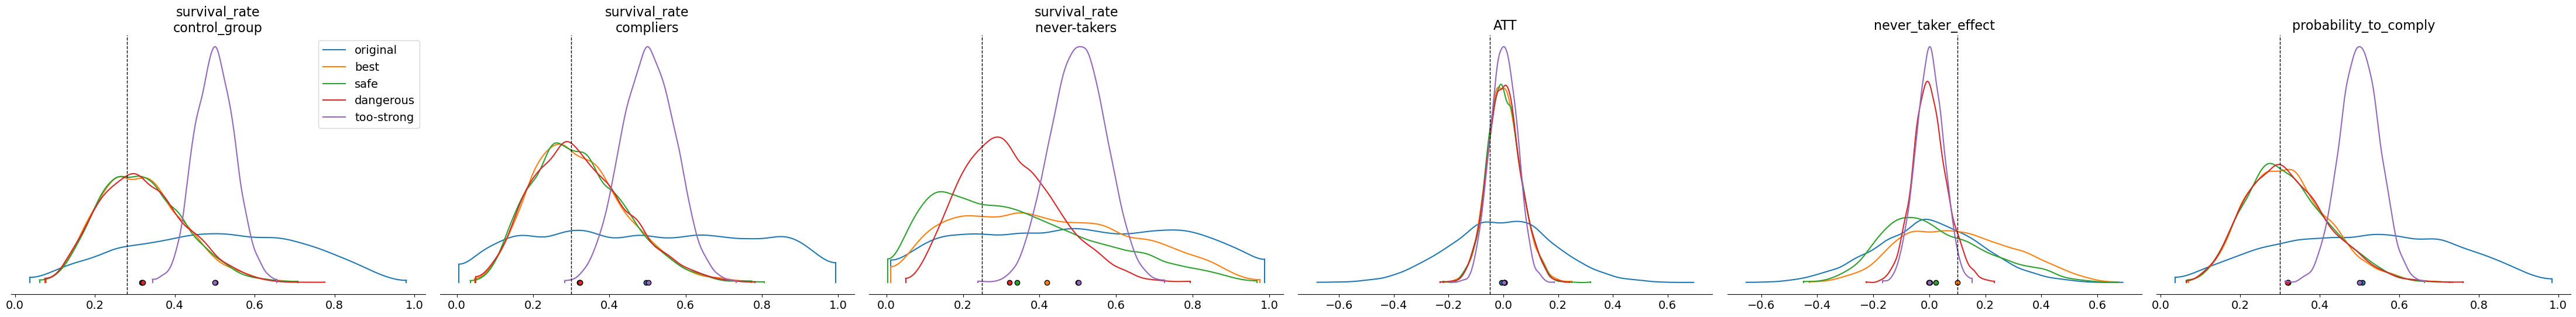

In [176]:
ax = az.plot_density(
    list(traces.values()),
    group="prior",
    var_names=["survival_rate", "ATT", "never_taker_effect", "probability_to_comply"],
    data_labels=traces.keys(),
    hdi_prob=1,
    shade=0,
    grid=(1, 6),
)

plt.tight_layout()

#show true values

#control group survival rate
ax[0,0].axvline(
    x=(outcome_rates[1] * real_compliance_rate) + ((1 - real_compliance_rate) * outcome_rates[0]), color="black", linestyle="--", label="zero", linewidth=1
)

#complier survival rate
ax[0,1].axvline(
    x=(outcome_rates + treatment_effect)[1], color="black", linestyle="--", label="zero", linewidth=1
)

#never-taker survival rate
ax[0,2].axvline(
    x=outcome_rates[0], color="black", linestyle="--", label="zero", linewidth=1
)

#treatment effect
ax[0,3].axvline(
    x=treatment_effect[1], color="black", linestyle="--", label="zero", linewidth=1
)

#never-taker effect
ax[0,4].axvline(
    x=outcome_rates[1] - outcome_rates[0], color="black", linestyle="--", label="zero", linewidth=1
)

#compliance rate
ax[0,5].axvline(
    x=real_compliance_rate, color="black", linestyle="--", label="zero", linewidth=1
)

And now, let's see to what estimates they lead to

In [177]:
for name, model in models.items():
    model_with_data = assign_data(
        model, simulated_df
    )

    with model_with_data:
        traces[name].extend(
        pm.sample(
            draws=4000,
            tune=1000,
            chains=4,
            nuts_sampler="nutpie",  
            progressbar=False
        )
    )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,5000,0,0.50,5
,5000,0,0.48,7
,5000,0,0.47,15
,5000,0,0.48,7


Progress,Draws,Divergences,Step Size,Gradients/Draw
,5000,0,0.46,7
,5000,0,0.50,7
,5000,0,0.50,3
,5000,0,0.52,15


Progress,Draws,Divergences,Step Size,Gradients/Draw
,5000,0,0.51,15
,5000,0,0.47,23
,5000,0,0.49,7
,5000,0,0.50,23


Progress,Draws,Divergences,Step Size,Gradients/Draw
,5000,0,0.51,3
,5000,0,0.52,3
,5000,0,0.55,3
,5000,0,0.53,15


Progress,Draws,Divergences,Step Size,Gradients/Draw
,5000,0,0.54,7
,5000,0,0.57,7
,5000,0,0.53,7
,5000,0,0.55,7


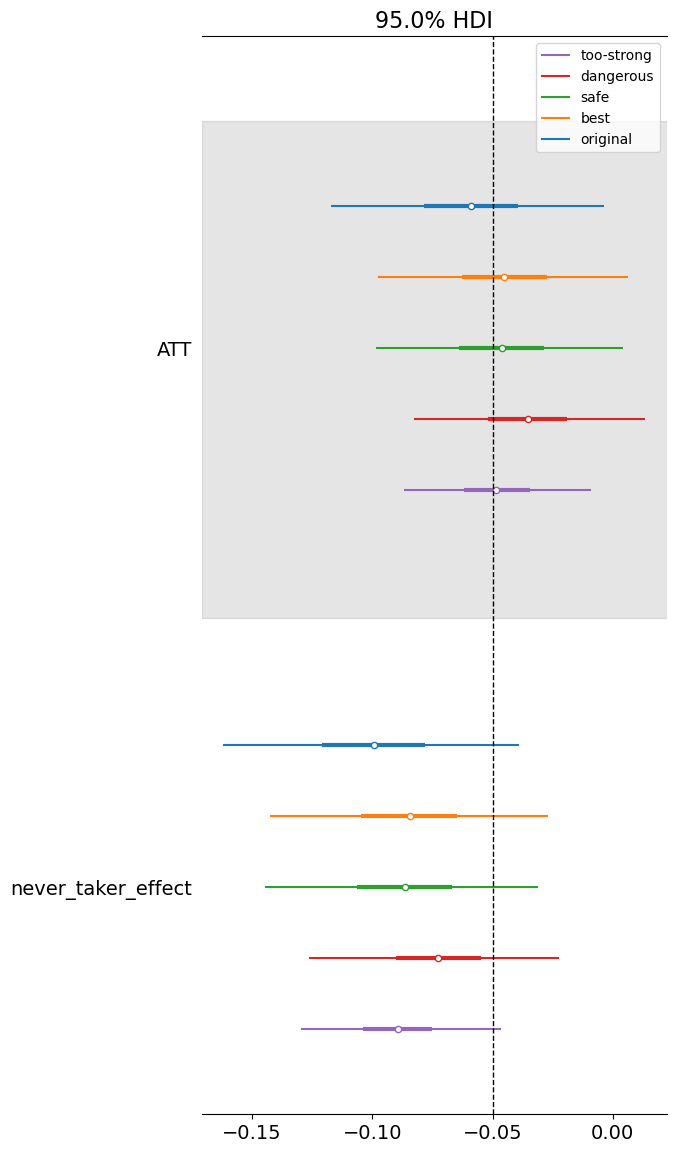

In [180]:
ax = az.plot_forest(
    list(traces.values()),
    var_names=["ATT", "never_taker_effect"],
    hdi_prob=0.95,
    model_names=traces.keys(),    
    combined=True,
)

#treatment effect
ax[0].axvline(
    x=treatment_effect[1], color="black", linestyle="--", label="zero", linewidth=1
)

##never-taker effect
#ax[1].axvline(
    #x=outcome_rates[1] - outcome_rates[0], color="black", linestyle="--", label="zero", linewidth=1
#)

In [181]:
for k,v in traces.items():
    print(k)
    display(az.summary(
        v,
        hdi_prob=0.95,
        round_to=4,
        var_names=["survival_rate", "probability_to_comply", "ATT", "never_taker_effect"],
    ))

original


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
survival_rate[control_group],0.3514,0.0267,0.2997,0.4029,0.0005,0.0003,3455.7073,3951.2554,1.0010
survival_rate[compliers],0.2923,0.0117,0.2696,0.3155,0.0001,0.0001,18447.2029,12608.2512,1.0001
survival_rate[never-takers],0.2518,0.0073,0.2376,0.2664,0.0001,0.0001,6176.6860,8507.4831,1.0005
probability_to_comply,0.3013,0.0065,0.2887,0.3143,0.0001,0.0000,13496.3649,10247.6618,1.0007
ATT,-0.0591,0.0291,-0.1171,-0.0038,0.0005,0.0003,3808.8694,4932.6322,1.0011
never_taker_effect,-0.0995,0.0318,-0.1622,-0.0391,0.0005,0.0004,3463.6827,4165.0612,1.0010


best


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
survival_rate[control_group],0.3387,0.0248,0.2899,0.3865,0.0004,0.0003,3673.2909,3369.4338,1.0008
survival_rate[compliers],0.2936,0.0116,0.2714,0.3169,0.0001,0.0001,18596.9422,12501.9443,1.0007
survival_rate[never-takers],0.2540,0.0072,0.2395,0.2676,0.0001,0.0001,6315.6180,8692.3762,1.0004
probability_to_comply,0.3013,0.0065,0.2891,0.3143,0.0001,0.0000,13814.1324,10449.1297,1.0005
ATT,-0.0451,0.0267,-0.0977,0.0064,0.0004,0.0003,4132.1259,4504.7464,1.0005
never_taker_effect,-0.0847,0.0296,-0.1426,-0.0270,0.0005,0.0003,3654.0476,3243.7399,1.0008


safe


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
survival_rate[control_group],0.3402,0.0244,0.2940,0.3892,0.0004,0.0003,3488.1296,3983.9492,1.0007
survival_rate[compliers],0.2938,0.0115,0.2705,0.3156,0.0001,0.0001,16848.5069,13023.4990,1.0000
survival_rate[never-takers],0.2536,0.0071,0.2394,0.2671,0.0001,0.0001,6386.7254,8016.3795,1.0004
probability_to_comply,0.3014,0.0064,0.2889,0.3139,0.0001,0.0000,14509.1108,10733.1010,1.0003
ATT,-0.0463,0.0262,-0.0986,0.0042,0.0004,0.0003,3805.2093,5025.8800,1.0010
never_taker_effect,-0.0866,0.0292,-0.1448,-0.0311,0.0005,0.0004,3482.8288,4272.5444,1.0010


dangerous


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
survival_rate[control_group],0.3288,0.0224,0.2870,0.3749,0.0004,0.0003,3783.5152,4310.7025,1.0010
survival_rate[compliers],0.2933,0.0115,0.2703,0.3151,0.0001,0.0001,17497.5628,12503.6626,1.0001
survival_rate[never-takers],0.2563,0.0068,0.2432,0.2699,0.0001,0.0001,7538.6795,9459.4874,1.0004
probability_to_comply,0.3013,0.0065,0.2883,0.3136,0.0001,0.0000,14118.1326,10306.9732,1.0003
ATT,-0.0355,0.0245,-0.0827,0.0136,0.0004,0.0003,4256.4668,5354.9802,1.0006
never_taker_effect,-0.0725,0.0266,-0.1265,-0.0223,0.0004,0.0003,3790.6632,4035.9437,1.0010


too-strong


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
survival_rate[control_group],0.3441,0.0179,0.3091,0.3784,0.0003,0.0002,3503.6848,5200.6316,1.0009
survival_rate[compliers],0.2958,0.0114,0.2741,0.3187,0.0001,0.0001,18315.5388,12692.2080,1.0001
survival_rate[never-takers],0.2545,0.0063,0.2425,0.2672,0.0001,0.0000,8526.0157,10940.5347,1.0002
probability_to_comply,0.3052,0.0064,0.2926,0.3177,0.0001,0.0000,14099.1266,10552.4147,1.0010
ATT,-0.0483,0.0200,-0.0870,-0.0092,0.0003,0.0002,4330.6958,6704.8467,1.0006
never_taker_effect,-0.0896,0.0213,-0.1295,-0.0464,0.0004,0.0003,3525.8577,5148.3301,1.0008


In [126]:
oracle_model(simulated_df)

{'name': 'true_complier:Z',
 'mean': '-0.0557',
 'st_error': '0.0168',
 't_stat': '-3.3138',
 'p_value': '0.0009',
 'lower_ci': '-0.0886',
 'upper_ci': '-0.0227'}

In [127]:
iv_estimator(simulated_df)

{'name': 'W',
 'mean': '-0.0580',
 'st_error': '0.0297',
 't_stat': '-1.9559',
 'p_value': '0.0505',
 'lower_ci': '-0.1161',
 'upper_ci': '0.0001'}